In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import numpy as np
from h5py import File
from fish.image.zds import ZDS
from fish.image.vol import InterpArray
from os.path import exists
import dask.array as da
from dask.distributed import Client
from scipy.ndimage.filters import median_filter

import flika as flk
flk.start_flika()
from flika.window import Window as flw

def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def get_klab_dataset(path):
    from glob import glob
    from fish.util.fileio import to_dask
    files = sorted(glob(path + 'TM*/*/*CM0*'))
    dsk = to_dask(files).squeeze().transpose(0,3,2,1)
    
    return dsk

Starting flika
Starting flika inside IPython


In [2]:
data = get_klab_dataset('/nrs/keller/ForDavis/Dme_L1_57C10GCaMP641-54B03TDT_0_20130912_145536.corrected/SPM00/')
data = data[750:]

In [3]:
reg_dir = '/groups/ahrens/ahrenslab/davis/tmp/Dme_L1_57C10GCaMP641-54B03TDT_0/'
if not exists(reg_dir):
    from os import makedirs
    makedirs(reg_dir)

In [4]:
# 8 ms exposure * 40 planes
fs_im = (.08 * 40)

In [5]:
data.shape

(1051, 40, 1386, 784)

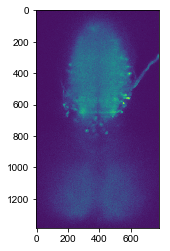

In [97]:
roi = slice(None), slice(20,21), slice(None), slice(None)
crop=slice(None), slice(None), slice(None), slice(None)
sample = data[roi][-1].compute(scheduler='threads').squeeze()
plt.imshow(sample)

In [7]:
window_seconds = 90
window_frames = int(window_seconds * fs_im)
camera_baseline = 80
perc = 20

def mybl(v):
    from fish.image.vol import baseline
    window = window_frames
    percentile = perc
    downsample = 1;
    return baseline(v, window, percentile, downsample, axis=0).astype('float32')

def mydff(v):
    return (v / mybl(v).clip(1,None))

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0] 
    im_ = im
    if im.dtype == 'float16':
        im_ = im.astype('float32')
    return shift(im_, (0,0, *shifts[t]), order=1, cval=100).astype(im.dtype)


In [8]:
from fish.util.distributed import get_jobqueue_cluster
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

/groups/ahrens/home/bennettd/miniconda/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://10.36.111.12:38339 Dashboard: http://10.36.111.12:44412/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
data_filt = data[roi].astype('float32')
rechunked = data_filt.rechunk((-1, 'auto', 'auto','auto'))

In [44]:
cluster.start_workers(100)
sample_t = data_filt.compute().squeeze()
cluster.stop_all_jobs()

In [45]:
win = flw(sample_t)

/groups/ahrens/home/bennettd/miniconda/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


In [46]:
1 + 1

2

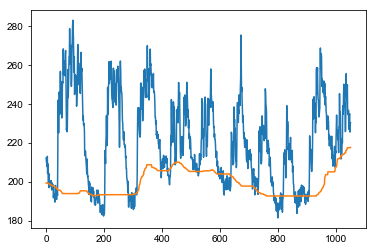

In [87]:
trace = win.rois[0].getTrace()
plt.plot(trace)
plt.plot(mybl(trace))

In [36]:
from fish.util.distributed import get_downsampled_baseline
from os.path import exists
from os import remove
ds_factors = [12, 24, 36, 48]
steps = [data.shape[0]//k for k in ds_factors]

window = window_frames
compute_baselines = True
bl_fnames = [reg_dir + f'baseline_ds{ds}.h5' for ds in ds_factors]
if compute_baselines:
    
    [remove(b) for b in bl_fnames if exists(b)]

    params = [get_downsampled_baseline(data_filt, factor=ds, window=window, perc=perc) for ds in ds_factors]
    cluster.start_workers(400)

    for ind, p in enumerate(params):
        fn = bl_fnames[ind]
        with File(fn, mode='a') as fh:
            try:
                fh['keyframes'] = p[0]
            except:
                fh['keyframes'][()] = p[0]
            dsb_ = p[1].compute()
            try:
                fh['baseline'][(slice(None), *roi[1:])] = dsb_
            except:
                fh.create_dataset('baseline', (len(p[0]), *data.shape[1:]))
                fh['baseline'][(slice(None), *roi[1:])] = dsb_

cluster.stop_all_jobs()

In [ ]:
# make some baselines 

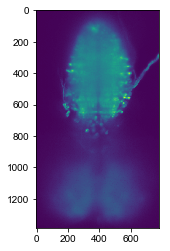

In [94]:
plt.imshow(blfull_.max(0))

In [98]:
cluster.start_workers(100)
errs = [] 
blfull_ = (rechunked[crop] - camera_baseline).map_blocks(mybl, dtype='float32').squeeze().compute()

tcrop = slice(window_frames//2, -window_frames//2)

for bl_fname in bl_fnames:
    bl_h5 = da.from_array(File(bl_fname, libver='latest', mode='r')['baseline'], chunks=data.chunksize).astype('float32')
    kf = File(bl_fname, mode='r')['keyframes'][:]
    dsb = InterpArray(kf, bl_h5, full_shape=data.shape, interpolation_axis=0)[roi].astype('float32')        
    
    blds_ = (dsb[crop] - camera_baseline).squeeze().compute()
    err = ((blds_[tcrop] / blfull_[tcrop]) - 1)
    
    result = err.mean(0), err.max(0)
    errs.append(result)
    
cluster.stop_all_jobs()
errs = np.array(errs)

In [43]:
flw(blfull_)

/groups/ahrens/home/bennettd/miniconda/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


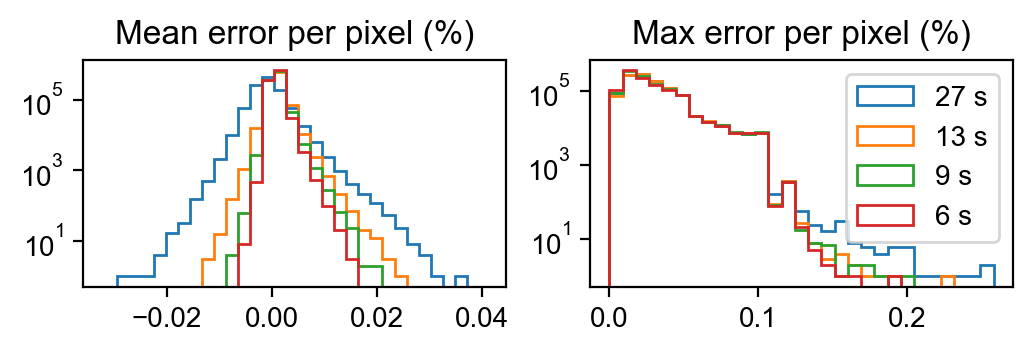

In [99]:
nbins = 30
bins_mean = np.linspace(errs[:,0].ravel().min(), errs[:,0].ravel().max(), nbins)
bins_max = np.linspace(np.abs(errs[:,1]).ravel().min(), np.abs(errs[:,1]).ravel().max(), nbins)

fig, axs = plt.subplots(ncols=2, figsize=(6,1.5), dpi=200)

[axs[0].hist(err[0].ravel(), bins=bins_mean, histtype='step') for err in errs];
[axs[1].hist(np.abs(err[1]).ravel(), bins=bins_max, histtype='step', label=f'{int(steps[ind]/fs_im)} s') for ind, err in enumerate(errs)];
axs[0].set_xlim(np.abs(axs[0].get_xlim()) * np.array([-1.1,1.1]))
axs[0].title.set_text('Mean error per pixel (%)')
axs[1].title.set_text('Max error per pixel (%)')

axs[1].legend()
[ax.semilogy() for ax in axs]
plt.savefig(f'/groups/ahrens/ahrenslab/davis/thesis/baseline_error_klab_plots.pdf')

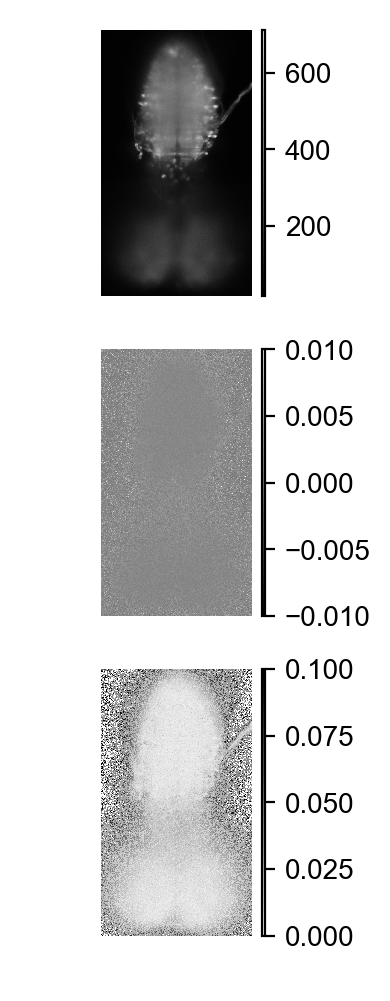

In [100]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(figsize=(4,6),nrows=3, dpi=200)
axs[0].imshow(blfull_[0], cmap='gray')
axs[1].imshow(errs[-1,0], cmap='gray', clim=(-.01, .01))
axs[2].imshow(errs[-1,1], cmap='gray_r', clim=(0,.1))

for ax in axs:
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(ax.images[0], cax=cax)
plt.savefig('/groups/ahrens/ahrenslab/davis/thesis/baseline_error_klab_images.pdf')

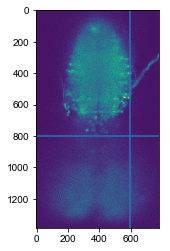

In [69]:
plt.imshow(sample_t[0])
plt.axhline(pt[0])
plt.axvline(pt[1])